In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

import statsmodels.api as sm


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.callbacks import TensorBoard
import datetime

import tensorflow as tf
import os

from sklearn.svm import SVR


In [41]:
data = pd.read_csv(r"C:\Users\diman\Downloads\Chess_Elo_Guesser\Data_trasnfomred7.csv")

In [42]:
data.head()

,player_color,player_elo,opponent_elo,result,time_control,rated,time_difference,blunders,mistakes,normal,...,maintained_bishop_pair,maintained_knight_pair,first_piece_take_move_number,second_piece_take_move_number,third_piece_take_move_number,num_legal_average,num_legal_std,total_blunders,total_mistakes,total_normal
0,0,1547,1399,0.0,300,True,602.0,6,8,15,...,0,1,10.0,11.0,12.0,33.666667,10.577665,8,19,32
1,0,1514,1536,1.0,300,True,47.0,1,1,2,...,1,1,NaN,NaN,NaN,27.900000,8.887569,1,2,6
2,0,1544,1452,1.0,300,True,295.0,3,8,19,...,1,0,8.0,11.0,11.0,29.524590,12.707749,6,17,37
3,0,857,821,1.0,300,True,627.0,22,17,15,...,1,0,10.0,11.0,17.0,28.697248,9.995837,42,33,33
4,0,829,817,1.0,300,True,490.0,12,12,10,...,1,0,12.0,13.0,23.0,31.086957,12.788712,26,22,20


In [43]:
def standardise_time(time_str):
    if '+' in time_str:
        base, increment = map(int, time_str.split('+'))
        return base + increment * 30
    else:
        return int(time_str)
data['time_control'] = data['time_control'].apply(standardise_time)


In [44]:
time_list = data['time_control'].unique().tolist()

print(time_list)

[300, 240, 600, 180, 510, 450, 360, 330, 630, 390, 420, 303]


In [45]:
data["Difference"] = data["player_elo"]-data["opponent_elo"]

In [46]:
data = data[(data['Difference'] < 700) & (data['Difference'] > -700)]


In [47]:
X = data.drop(columns=["player_elo","total_blunders", "total_mistakes","Difference"])

In [48]:
X["mistakes_per_move"] = X["mistakes"]/X["game_length"]
X["blunders_per_move"] = X["blunders"]/X["game_length"]
X["predicted_end"] = X["gradient"]*X["game_length"]
X["time_per_move"] = X["time_difference"]/X["game_length"]

In [49]:
def castled(x):
    if pd.isna(x["castle_moves"]):
        x["castled"] = 0
    else:
        x["castled"] = 1
    return x["castled"]
def first_piece_taken(x):
    if pd.isna(x["first_piece_take_move_number"]):
        x["first_piece_taken"] = 0
    else:
        x["first_piece_taken"] = 1
    return x["first_piece_taken"]
def second_piece_taken(x):
    if pd.isna(x["second_piece_take_move_number"]):
        x["second_piece_taken"] = 0
    else:
        x["second_piece_taken"] = 1
    return x["second_piece_taken"]
def third_piece_taken(x):
    if pd.isna(x["third_piece_take_move_number"]):
        x["third_piece_taken"] = 0
    else:
        x["third_piece_taken"] = 1
    return x["third_piece_taken"]

def handle_none(x):
    if pd.isna(x["castle_moves"]):
        return 2 * x["game_length"]
    else:
        return x["castle_moves"]
def handle_first_take_none(x):
    if pd.isna(x["first_piece_take_move_number"]):
        return 2 * x["game_length"]
    else:
        return x["first_piece_take_move_number"]
    
def handle_second_take_none(x):
    if pd.isna(x["second_piece_take_move_number"]):
        return 2 * x["game_length"]
    else:
        return x["second_piece_take_move_number"]
def handle_third_take_none(x):
    if pd.isna(x["third_piece_take_move_number"]):
        return 2 * x["game_length"]
    else:
        return x["third_piece_take_move_number"]


In [50]:
X["castled"] = X.apply(castled, axis=1)
X["first_piece_taken"] = X.apply(first_piece_taken, axis=1)
X["second_piece_taken"] = X.apply(second_piece_taken, axis=1)
X["third_piece_taken"] = X.apply(third_piece_taken, axis=1)

X["first_piece_take_filled"] = X.apply(handle_first_take_none, axis=1)
X["second_piece_take_filled"] = X.apply(handle_second_take_none, axis=1)
X["third_piece_take_filled"] = X.apply(handle_third_take_none, axis=1)

In [51]:
X["castle_moves_filled"] = X.apply(handle_none, axis=1)

In [52]:
X.drop(["castle_moves"], axis=1, inplace=True)

In [53]:
X.drop(["first_piece_take_move_number", "second_piece_take_move_number", "third_piece_take_move_number"], axis=1, inplace=True)


In [54]:
missing_values = X.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 player_color                0
opponent_elo                0
result                      0
time_control                0
rated                       0
time_difference             0
blunders                    0
mistakes                    0
normal                      0
gradient                    0
variance                    0
average_eval                0
average_eval_change         0
game_length                 0
opening_name                0
opening_move_number         0
opening_type                0
castle_moves_diff           0
piece_moves_ind_B           0
piece_moves_ind_N           0
piece_moves_ind_R           0
piece_moves_ind_Q           0
piece_moves_ind_K           0
piece_moves_ind_+           0
piece_moves_total_B         0
piece_moves_total_N         0
piece_moves_total_R         0
piece_moves_total_Q         0
piece_moves_total_K         0
piece_moves_total_+         0
aggro_pawn_a                0
aggro_pawn_b                0
aggro_pawn_g           

In [55]:
def add_squared_features(df, columns):
    data_new = df.copy()
    for col in columns:
        if col in df.columns:
            data_new[f"{col}_squared"] = df[col] ** 2
        else:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
    return data_new

In [56]:
#X = add_squared_features(X, X.columns)

In [57]:
X = X.drop(columns=["opponent_elo"])

In [58]:
y = data["Difference"]

In [59]:
X = X.drop(columns=["opening_name"])

In [60]:
X = X.drop(columns=["opening_type"])

In [61]:
y = pd.DataFrame(y)

In [62]:
y["Difference"]

0        148
1        -22
2         92
3         36
4         12
        ... 
56773     35
56774      2
56775     10
56776      5
56777     -8
Name: Difference, Length: 56348, dtype: int64

In [63]:
average =y['Difference'].abs().mean()

print("Average Score:", average)

Average Score: 58.92645701710797


In [64]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)


In [66]:
X_train

,player_color,result,time_control,rated,time_difference,blunders,mistakes,normal,gradient,variance,...,predicted_end,time_per_move,castled,first_piece_taken,second_piece_taken,third_piece_taken,first_piece_take_filled,second_piece_take_filled,third_piece_take_filled,castle_moves_filled
55297,1,0.0,600,True,910.0,6,14,23,0.023472,8.190923,...,2.042077,10.459770,0,1,1,1,7.0,10.0,11.0,174.0
22406,0,1.0,300,True,198.0,2,8,14,0.010233,3.510202,...,0.501400,4.040816,1,1,1,1,6.0,7.0,8.0,12.0
16765,0,1.0,600,True,833.0,4,7,10,-0.012662,6.921577,...,-0.544481,19.372093,0,1,1,1,12.0,13.0,20.0,86.0
36054,1,0.5,300,True,498.0,11,18,15,-0.123122,14.192717,...,-10.834754,5.659091,0,1,1,1,16.0,17.0,20.0,176.0
46332,1,1.0,600,True,393.0,0,3,17,-0.095040,2.446515,...,-3.801614,9.825000,1,1,1,1,6.0,7.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38318,1,0.0,240,True,241.0,1,5,19,0.143947,5.428503,...,7.341277,4.725490,1,1,1,1,9.0,10.0,14.0,10.0
53775,1,1.0,180,True,338.0,4,17,30,-0.078135,6.609506,...,-7.969786,3.313725,1,1,1,1,15.0,16.0,17.0,8.0
22206,0,1.0,180,True,289.0,8,15,24,0.044986,18.600345,...,4.273670,3.042105,1,1,1,1,10.0,11.0,15.0,10.0
54839,1,1.0,300,True,85.0,0,3,16,-0.120988,3.900862,...,-4.597547,2.236842,1,1,1,1,14.0,15.0,15.0,7.0


In [67]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)  # or use np.sqrt(mse)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 9381.7387
Root Mean Squared Error (RMSE): 9381.7387
Mean Absolute Error (MAE): 56.1733
R² Score: 0.1359


In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [69]:
tree = DecisionTreeRegressor(max_depth=9, min_samples_split=5, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)  # or use np.sqrt(mse)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 9889.7750
Root Mean Squared Error (RMSE): 9889.7750
Mean Absolute Error (MAE): 56.0629
R² Score: 0.0891


In [70]:
missing_values = X_train.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 player_color                0
result                      0
time_control                0
rated                       0
time_difference             0
blunders                    0
mistakes                    0
normal                      0
gradient                    0
variance                    0
average_eval                0
average_eval_change         0
game_length                 0
opening_move_number         0
castle_moves_diff           0
piece_moves_ind_B           0
piece_moves_ind_N           0
piece_moves_ind_R           0
piece_moves_ind_Q           0
piece_moves_ind_K           0
piece_moves_ind_+           0
piece_moves_total_B         0
piece_moves_total_N         0
piece_moves_total_R         0
piece_moves_total_Q         0
piece_moves_total_K         0
piece_moves_total_+         0
aggro_pawn_a                0
aggro_pawn_b                0
aggro_pawn_g                0
aggro_pawn_h                0
aggro_pawn_total            0
takes                  

In [71]:
forrest = RandomForestRegressor(n_estimators=220, max_depth=30, min_samples_leaf=4, bootstrap=True, oob_score=True, random_state=42)
forrest.fit(X_train, y_train)
y_pred = forrest.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

c:\Users\diman\Downloads\ML\lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 9006.8415
Root Mean Squared Error (RMSE): 9006.8415
Mean Absolute Error (MAE): 55.0693
R² Score: 0.1704


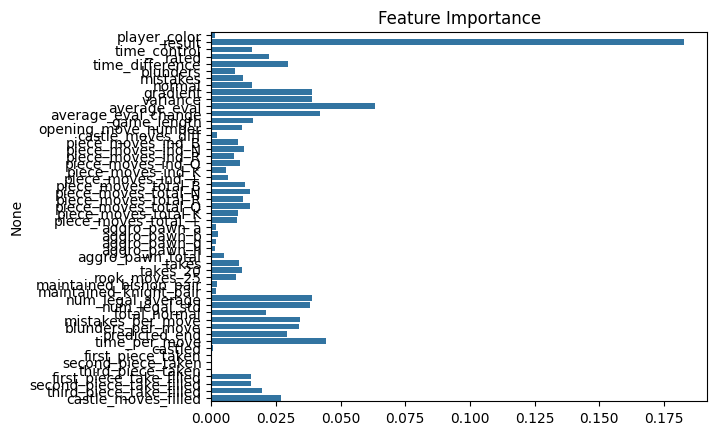

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = forrest.feature_importances_
features = X.columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

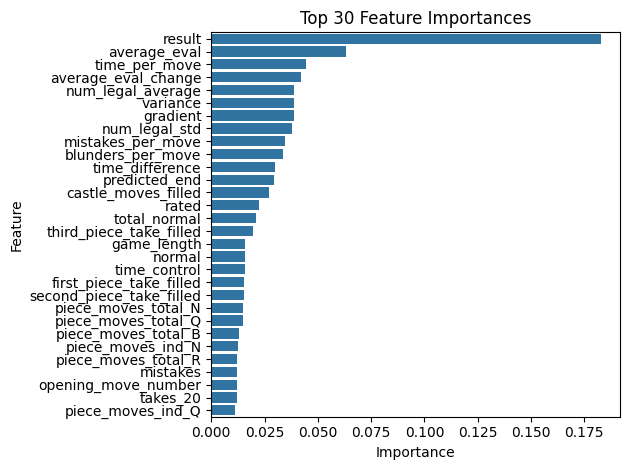

In [73]:
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance and take top 30
top_feats = feat_imp_df.sort_values(by='Importance', ascending=False).head(30)

# Plot
sns.barplot(x='Importance', y='Feature', data=top_feats)
plt.title("Top 30 Feature Importances")
plt.tight_layout()
plt.show()

# If you want to use only these features in X
X_top30 = X[top_feats['Feature'].values]

In [76]:
mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 9006.8415
Root Mean Squared Error (RMSE): 9006.8415
Mean Absolute Error (MAE): 55.0693
R² Score: 0.1704


In [77]:
y_pred.shape

(9016,)

In [78]:
model_XGB = XGBRegressor(n_estimators=200, learning_rate=0.03, max_depth=15, random_state=42,reg_lambda=0.5)
model_XGB.fit(X_train, y_train)
y_pred = model_XGB.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred)
rmse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 9718.2109
Root Mean Squared Error (RMSE): 9718.2109
Mean Absolute Error (MAE): 57.8039
R² Score: 0.1049


In [79]:
print(X.dtypes)


player_color                  int64
result                      float64
time_control                  int64
rated                          bool
time_difference             float64
blunders                      int64
mistakes                      int64
normal                        int64
gradient                    float64
variance                    float64
average_eval                float64
average_eval_change         float64
game_length                   int64
opening_move_number           int64
castle_moves_diff             int64
piece_moves_ind_B             int64
piece_moves_ind_N             int64
piece_moves_ind_R             int64
piece_moves_ind_Q             int64
piece_moves_ind_K             int64
piece_moves_ind_+             int64
piece_moves_total_B           int64
piece_moves_total_N           int64
piece_moves_total_R           int64
piece_moves_total_Q           int64
piece_moves_total_K           int64
piece_moves_total_+           int64
aggro_pawn_a                

In [80]:
X2 = X.astype({col: int for col in X.select_dtypes("bool").columns})


In [81]:
X2 =pd.DataFrame(X2)
X_with_const = sm.add_constant(X2)
X_with_const = pd.DataFrame(X_with_const)
y = pd.DataFrame(y)
# 2. Fit the model
model = sm.OLS(y, X_with_const).fit()

# 3. Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     166.1
Date:                Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:03:03   Log-Likelihood:            -3.3635e+05
No. Observations:               56348   AIC:                         6.728e+05
Df Residuals:                   56296   BIC:                         6.733e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [82]:
X_train

,player_color,result,time_control,rated,time_difference,blunders,mistakes,normal,gradient,variance,...,predicted_end,time_per_move,castled,first_piece_taken,second_piece_taken,third_piece_taken,first_piece_take_filled,second_piece_take_filled,third_piece_take_filled,castle_moves_filled
55297,1,0.0,600,True,910.0,6,14,23,0.023472,8.190923,...,2.042077,10.459770,0,1,1,1,7.0,10.0,11.0,174.0
22406,0,1.0,300,True,198.0,2,8,14,0.010233,3.510202,...,0.501400,4.040816,1,1,1,1,6.0,7.0,8.0,12.0
16765,0,1.0,600,True,833.0,4,7,10,-0.012662,6.921577,...,-0.544481,19.372093,0,1,1,1,12.0,13.0,20.0,86.0
36054,1,0.5,300,True,498.0,11,18,15,-0.123122,14.192717,...,-10.834754,5.659091,0,1,1,1,16.0,17.0,20.0,176.0
46332,1,1.0,600,True,393.0,0,3,17,-0.095040,2.446515,...,-3.801614,9.825000,1,1,1,1,6.0,7.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38318,1,0.0,240,True,241.0,1,5,19,0.143947,5.428503,...,7.341277,4.725490,1,1,1,1,9.0,10.0,14.0,10.0
53775,1,1.0,180,True,338.0,4,17,30,-0.078135,6.609506,...,-7.969786,3.313725,1,1,1,1,15.0,16.0,17.0,8.0
22206,0,1.0,180,True,289.0,8,15,24,0.044986,18.600345,...,4.273670,3.042105,1,1,1,1,10.0,11.0,15.0,10.0
54839,1,1.0,300,True,85.0,0,3,16,-0.120988,3.900862,...,-4.597547,2.236842,1,1,1,1,14.0,15.0,15.0,7.0


In [95]:
y_train

,Difference
55297,50
22406,28
16765,57
36054,-4
46332,16
...,...
38318,5
53775,21
22206,41
54839,94


In [97]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

In [98]:
scaler_y = StandardScaler()
y_train = pd.DataFrame(y_train)
y_eval = pd.DataFrame(y_eval)

y_train_scaled = scaler_y.fit_transform(y_train)
y_eval_scaled  = scaler_y.transform(y_eval)

In [100]:
X_train_scaled = pd.DataFrame(X_train_scaled)

In [101]:
X_eval_scaled = pd.DataFrame(X_eval_scaled)

In [102]:
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from keras.regularizers import l2


In [114]:
model = Sequential([
    Dense(52, kernel_initializer=GlorotUniform(), input_shape=(52,)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.2),

    Dense(30, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(30, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(15, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(15, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.1),

    Dense(5, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),

    Dense(1)
])


c:\Users\diman\Downloads\ML\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [115]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [116]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.5,
    patience = 7,
    min_lr = 1e-6,
    verbose=1
)

In [117]:
#optimizer = Adam(learning_rate=0.01)
#optimizer = SGD(learning_rate=0.2, momentum=0.9)

model.compile(optimizer='adam', loss='mae')


In [118]:
y_train

,Difference
55297,50
22406,28
16765,57
36054,-4
46332,16
...,...
38318,5
53775,21
22206,41
54839,94


In [ ]:
base_log_dir = r"C:\Users\diman\Downloads\Chess_Elo_Guesser"
run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(base_log_dir, "logs", run_id)


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [120]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [122]:
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_eval_scaled, y_eval_scaled), epochs=100, callbacks=[reduce_lr, early_stop])


Epoch 1/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5486 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 2/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5513 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 3/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5509 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 4/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5465 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 5/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5506 - val_loss: 0.5619 - learning_rate: 0.0010
Epoch 6/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5510 - val_loss: 0.5682 - learning_rate: 0.0010
Epoch 7/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5588 - val_loss: 0.5578 - learning_rate: 0.0010
Epoch 8/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5512 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 9/100
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5461 - val_loss: 0.5562 - learn

In [123]:
y_train_scaled

array([[ 0.49523034],
       [ 0.27657082],
       [ 0.56480382],
       ...,
       [ 0.40577872],
       [ 0.93254938],
       [-0.52849378]])

In [124]:
y_pred = model.predict(X_eval_scaled)

mse = mean_squared_error(y_eval_scaled, y_pred)
rmse = mean_squared_error(y_eval_scaled, y_pred)
mae = mean_absolute_error(y_eval_scaled, y_pred)
r2 = r2_score(y_eval_scaled, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
Mean Squared Error (MSE): 0.9368
Root Mean Squared Error (RMSE): 0.9368
Mean Absolute Error (MAE): 0.5445
R² Score: 0.1266


In [125]:
y_pred

array([[-0.24175124],
       [-0.24175124],
       [ 0.24971579],
       ...,
       [-0.24175124],
       [ 0.2123396 ],
       [ 0.02920349]], dtype=float32)

In [126]:
y_pred_unscaled = scaler_y.inverse_transform(y_pred)
y_eval_unscaled = scaler_y.inverse_transform(y_eval_scaled)
mse_unscaled = mean_squared_error(y_eval_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_eval_unscaled, y_pred_unscaled)


In [127]:
print(mse_unscaled)
print(mae)

9483.209941209901
54.780550332721766


In [ ]:
from tensorflow.keras.layers import Add, Input


def residual_block(x, units, dropout_rate=0.1, l2_reg=0.01):
    """Residual block with same input/output shape"""
    shortcut = x 

    x = Dense(units, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)


    if shortcut.shape[-1] != units:
        shortcut = Dense(units, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(l2_reg))(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
from tensorflow.keras.models import Model


In [134]:
def build_model(input_shape=(52,)):
    inputs = Input(shape=input_shape)
    
    x = Dense(52, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = residual_block(x, 52, dropout_rate=0.1, l2_reg=0.05)

    x = Dense(40, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = residual_block(x, 30, dropout_rate=0.1, l2_reg=0.05)

    x = Dense(30, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.05))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = residual_block(x, 15, dropout_rate=0.1, l2_reg=0.01)
    x = residual_block(x, 15, dropout_rate=0.1, l2_reg=0.01)

    x = Dense(5, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = residual_block(x, 5, dropout_rate=0.1, l2_reg=0.01)

    x = Dense(5, kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model

In [135]:
model = build_model()
model.compile(optimizer='adam', loss='huber')
#model.summary()

In [136]:
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_eval_scaled, y_eval_scaled), epochs=200, callbacks=[reduce_lr, early_stop])

Epoch 1/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5.4300 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 2/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3416 - val_loss: 0.4040 - learning_rate: 0.0010
Epoch 3/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3283 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 4/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3414 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 5/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3182 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 6/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3049 - val_loss: 0.3115 - learning_rate: 0.0010
Epoch 7/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2990 - val_loss: 0.3336 - learning_rate: 0.0010
Epoch 8/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3130 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 9/200
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3040 - val_loss: 0.3204 - learn

In [137]:
y_pred = model.predict(X_eval_scaled)

mse = mean_squared_error(y_eval_scaled, y_pred)
rmse = mean_squared_error(y_eval_scaled, y_pred)
mae = mean_absolute_error(y_eval_scaled, y_pred)
r2 = r2_score(y_eval_scaled, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
y_pred
y_pred_unscaled = scaler_y.inverse_transform(y_pred)
y_eval_unscaled = scaler_y.inverse_transform(y_eval_scaled)
mse_unscaled = mean_squared_error(y_eval_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_eval_unscaled, y_pred_unscaled)
print(mse_unscaled)
print(mae)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Squared Error (MSE): 0.9012
Root Mean Squared Error (RMSE): 0.9012
Mean Absolute Error (MAE): 0.5382
R² Score: 0.1597
9123.104295634608
54.147450146476054
